<a href="https://colab.research.google.com/github/kim-slava/komp_vision/blob/main/komp_vision_lab_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Архив содержит директории `train` и `validation`, каждая из которых содержит директории `cats` и `dogs`

In [ ]:
!unzip -q archive.zip              # папку с датасетом загружаем в корень и разархивируем

In [ ]:
!ls

archive  archive.zip  sample_data


In [ ]:
import os
import zipfile

In [ ]:
base_dir = '/content/archive'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

train_afr_leopard_dir = os.path.join(train_dir, 'AFRICAN LEOPARD')
train_caracal_dir = os.path.join(train_dir, 'CARACAL')
train_jaguar_dir = os.path.join(train_dir, 'JAGUAR')
train_lions_dir = os.path.join(train_dir, 'LIONS')

validation_afr_leopard_dir = os.path.join(validation_dir, 'AFRICAN LEOPARD')
validation_caracal_dir = os.path.join(validation_dir, 'CARACAL')
validation_jaguar_dir = os.path.join(validation_dir, 'JAGUAR')
validation_lions_dir = os.path.join(validation_dir, 'LIONS')

print(f'Директория train содержит {len(os.listdir(train_afr_leopard_dir))} изображений африкансих леопардов и {len(os.listdir(train_caracal_dir))} изображений караколов')
print(f'Директория validation содержит {len(os.listdir(validation_afr_leopard_dir))} изображений африкансих леопардов и {len(os.listdir(validation_caracal_dir))} изображений караколов')

Директория train содержит 209 изображений африкансих леопардов и 209 изображений караколов
Директория validation содержит 32 изображений африкансих леопардов и 32 изображений караколов


In [ ]:
from glob import glob
train_afr_leopard_files = glob(os.path.join(base_dir, 'train', 'AFRICAN LEOPARD', '*.jpg'))
train_caracal_files = glob(os.path.join(base_dir, 'train', 'CARACAL', '*.jpg'))
train_jaguar_files = glob(os.path.join(base_dir, 'train', 'JAGUAR', '*.jpg'))
train_lions_files = glob(os.path.join(base_dir, 'train', 'LIONS', '*.jpg'))
validation_afr_leopard_files = glob(os.path.join(base_dir, 'validation', 'AFRICAN LEOPARD', '*.jpg'))
validation_caracal_files = glob(os.path.join(base_dir, 'validation', 'CARACAL', '*.jpg'))
validation_jaguar_files = glob(os.path.join(base_dir, 'validation', 'JAGUAR', '*.jpg'))
validation_lions_files = glob(os.path.join(base_dir, 'validation', 'LIONS', '*.jpg'))

Покажем по 2 картинки каждого вида из папки `train`

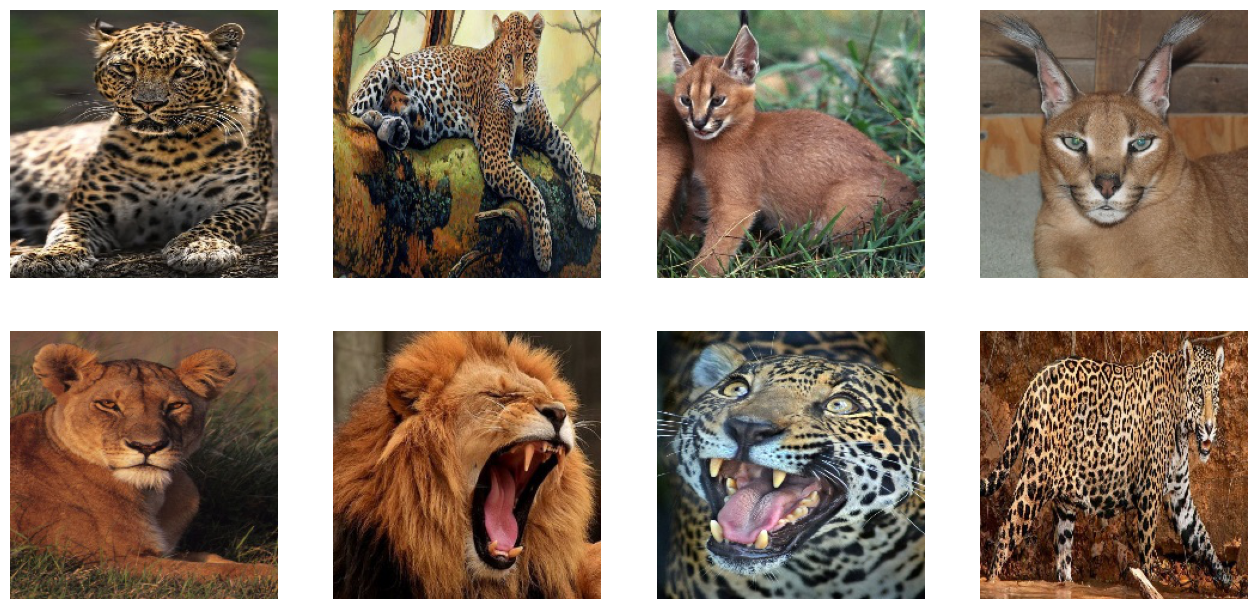

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows, ncols = 4, 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, img_path in enumerate(train_afr_leopard_files[:2]+train_caracal_files[:2]+train_lions_files[:2]+train_jaguar_files[:2]):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## построим и обучим простую сверточную сеть

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

model = Sequential([
  # входное изображение: 150*150*3

  # Cверточный слой: размер ядра 3*3, 1 канал на входе, 16 на выходе.
  # Форма тензора на входе (,150,150,3) трансформируется в (148,148,16)
  Conv2D(16, (3,3), input_shape=(150, 150, 3), activation='relu'),
  # Слой max-выборки: размер ядра 2*2, тензор (,148,148,16) трансформируется в (74,74,16)
  MaxPool2D((2,2)),

  # Второй сверточный слой
  Conv2D(32, (3,3), activation='relu'), # Форма тензора на входе (,74,74,16) -> (72,72,32)
  MaxPool2D((2,2)),                     # max-выборка: (,72,72,32) -> (36,36,32)

  # Третий сверточный слой
  Conv2D(64, (3,3), activation='relu'), # Форма тензора на входе (,36,36,16) -> (34,34,64)
  MaxPool2D((2,2)),                     # max-выборка: (,34,34,64) -> (17,17,64)

  # Заканчиваем сеть персептроном
  Flatten(),                            # (,17,17,64) -> (,18496)
  Dense(512, activation='relu'),        # Полносвязанный слой (,18496) -> (,512)
  #tf.keras.layers.Dropout(0.2),
  Dense(4, activation='sigmoid')        # Второй полносвязанный слой (,512) -> (,1)

])

model.compile(optimizer=RMSprop(learning_rate=0.001), #'adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 17, 17, 64)      

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='categorical')

Found 825 images belonging to 4 classes.
Found 132 images belonging to 4 classes.


In [ ]:
validation_generator

TypeError: ignored

In [ ]:
history = model.fit(
      train_generator,
      # steps_per_epoch=10,  # 2000 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      # validation_steps=5,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/30
83/83 - 2s - loss: 2.1674e-06 - accuracy: 1.0000 - val_loss: 1.2443 - val_accuracy: 0.7121 - 2s/epoch - 25ms/step
Epoch 2/30
83/83 - 2s - loss: 1.8285e-06 - accuracy: 1.0000 - val_loss: 1.2219 - val_accuracy: 0.7121 - 2s/epoch - 24ms/step
Epoch 3/30
83/83 - 2s - loss: 1.6633e-06 - accuracy: 1.0000 - val_loss: 1.2315 - val_accuracy: 0.7121 - 2s/epoch - 25ms/step
Epoch 4/30
83/83 - 3s - loss: 1.5397e-06 - accuracy: 1.0000 - val_loss: 1.2473 - val_accuracy: 0.7121 - 3s/epoch - 35ms/step
Epoch 5/30
83/83 - 2s - loss: 1.3804e-06 - accuracy: 1.0000 - val_loss: 1.2738 - val_accuracy: 0.7121 - 2s/epoch - 24ms/step
Epoch 6/30
83/83 - 2s - loss: 1.2704e-06 - accuracy: 1.0000 - val_loss: 1.2750 - val_accuracy: 0.7121 - 2s/epoch - 25ms/step
Epoch 7/30
83/83 - 2s - loss: 1.2134e-06 - accuracy: 1.0000 - val_loss: 1.2792 - val_accuracy: 0.7121 - 2s/epoch - 24ms/step
Epoch 8/30
83/83 - 2s - loss: 1.1216e-06 - accuracy: 1.0000 - val_loss: 1.2777 - val_accuracy: 0.7197 - 2s/epoch - 25ms/step


In [ ]:
from IPython.lib.display import TextDisplayObject


test = ImageDataGenerator(rescale=1./255)
dir = '/content/archive/test/AFRICAN LEOPARD'
# train_dir = os.path.join(base_dir, 'train')
# Flow training images in batches of 20 using train_datagen generator
test_generator = test.flow_from_directory(
        dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

model.predict(test_generator)

Found 0 images belonging to 0 classes.


ValueError: ignored

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.vgg16 import preprocess_input


# load model
vgg_feature_extractor = VGG16(include_top=False, input_shape=(224, 224, 3))
# mark loaded layers as not trainable
for layer in vgg_feature_extractor.layers:
  layer.trainable = False
# add new classifier layers
flat1 = Flatten()(vgg_feature_extractor.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)
# define new model
model_2 = Model(inputs=vgg_feature_extractor.inputs, outputs=output)
# compile model
#opt = SGD(lr=0.001, momentum=0.9)
model_2.compile(optimizer=RMSprop(learning_rate=0.001), #'adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator_2 = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=2,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator_2 = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=2,
        class_mode='binary')

history_2 = model_2.fit(
      train_generator_2,
      steps_per_epoch=1000,  # 2000 images = batch_size * steps
      epochs=3,
      validation_data=validation_generator_2,
      validation_steps=500,  # 1000 images = batch_size * steps
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/3
1000/1000 - 24s - loss: 0.4647 - accuracy: 0.8135 - val_loss: 0.4988 - val_accuracy: 0.7970 - 24s/epoch - 24ms/step
Epoch 2/3
1000/1000 - 22s - loss: 0.2138 - accuracy: 0.9215 - val_loss: 0.5045 - val_accuracy: 0.8470 - 22s/epoch - 22ms/step
Epoch 3/3
1000/1000 - 22s - loss: 0.1843 - accuracy: 0.9440 - val_loss: 0.2949 - val_accuracy: 0.9120 - 22s/epoch - 22ms/step


**Индивидуальные задания**:
подготовьте набор данных, содержащих не менее 100 обучающих изображений в не менее чем 3 классах + по 20 изображений каждого класса для теста и обучите классификатор различать эти изображения.